# Libraries

In [1]:
import sys
import os
import re
import math
import MDAnalysis as mda 
import matplotlib.pyplot as plt
from MDAnalysis.analysis import align
import numpy as np
import pandas as pd
import itertools
from sklearn.ensemble import RandomForestClassifier
import gc
import glob as g

# Define Paths, pH, and CRD Files

In [2]:
# pH range 
pH = "7.0"
# Location of PSF and DCD
path1  = "/data/jackh/plasmepsin/apo_plasmepsin/run"
path2  = "/data/jackh/plasmepsin/holo_plasmepsin/run"
direc = "stage"
# Name of apo psf and initial crds 
psf1 = '{}/plasmepsin.psf'.format(path1)
crd1 = '{}/plasmepsin.crd'.format(path1)
psf2 = '{}/1sme.psf'.format(path2)
crd2 = '{}/1sme.crd'.format(path2)
# Stage Ranges 
sstage1 = 61
lstage1 = 65
sstage2 = 41
lstage2 = 41

# Align Frames and extract portion of interest

### Function for Remaking Trajectories

In [3]:
def traj_aligner(psf, crd, sstage, lstage, path, direc, skip, o_name='test'):
    '''
    Libraries Needed: import MDAnalysis as mda 
                      import Glob as g
                      from MDAnalysis.analysis import align
                      import os
    psf, for current system 
    crd, for current system
    sstage, start stage
    lstage, last stage
    '''
    ref = mda.Universe(psf, crd, format='CRD')
    out_selection = ref.select_atoms("protein")
    other_selection  = ref.select_atoms("protein")
    with mda.Writer('pdb_for_coloring.pdb', other_selection.n_atoms) as o:
        o.write(other_selection)
    with mda.Writer('check.pdb', out_selection.n_atoms) as o:
        o.write(out_selection)
    with mda.Writer('{}.dcd'.format(o_name), out_selection.n_atoms) as w:
        frame = 0
        for stage in range(sstage, lstage+1):
            dcd = g.glob('{}/{}{}/*ph{}*dcd*'.format(path, direc, stage, pH))[0]
            u = mda.Universe(psf, dcd, format='DCD')
            alignment = align.AlignTraj(u, ref, filename='align.dcd', select="name C CA N O")
            alignment.run()
            aligned = mda.Universe(psf, 'align.dcd', format='DCD')
            selection = aligned.select_atoms('protein')
            for ts in aligned.trajectory[::skip]:
                w.write(selection)
                frame += 1
            os.remove('align.dcd')
            gc.collect()

### Get data from Apo

In [4]:
traj_aligner(psf1, crd1, sstage1, lstage1, path1, direc, 10, o_name='apo')

/home/jackh/Software/anaconda3/lib/python3.7/site-packages/MDAnalysis/coordinates/PDB.py:864: DeprecationWarning: Using the last letter of the segid for the chainID is now deprecated and will be changed in 2.0. In 2.0, the chainID attribute will be used if it exists, or a placeholder value.
  "exists, or a placeholder value.", DeprecationWarning)
/home/jackh/Software/anaconda3/lib/python3.7/site-packages/MDAnalysis/coordinates/PDB.py:722: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/home/jackh/Software/anaconda3/lib/python3.7/site-packages/MDAnalysis/coordinates/PDB.py:1032: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  "".format(attrname, default))
/home/jackh/Software/anaconda3/lib/python3.7/site-packages/MDAnalysis/coordinates/PDB.py:1032: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  "".format(attrname, default))
/home/jac

### Get data from Holo

In [5]:
traj_aligner(psf2, crd2, sstage2, lstage2, path2, direc, 10, o_name='holo')

### Create new Universes for Mutant and Wild Type Trajectories

In [6]:
apo  = mda.Universe('check.pdb', 'apo.dcd', format='DCD')
holo = mda.Universe('check.pdb', 'holo.dcd', format='DCD')

In [7]:
print('Number of Apo  Data Points: {}'.format(len(apo.trajectory)))
print('Number of Holo Data Points: {}'.format(len(holo.trajectory)))

Number of Apo  Data Points: 250
Number of Holo Data Points: 200


# Process Data

### Make Selections 

In [8]:
selection = 'protein and name CA'
apo_select = apo.select_atoms(selection)
holo_select = holo.select_atoms(selection)
print('Number of Atoms in apo Selection: {}'.format(len(apo_select)))
print('Number of Atoms in holo Selection: {}'.format(len(holo_select)))

Number of Atoms in apo Selection: 329
Number of Atoms in holo Selection: 329


Get the Data for the Apo State and Create a  Labeled DataFrame

In [9]:
apo_data = []
for ts in apo.trajectory:
    all_coors = []
    coors = apo_select.positions
    for three in coors:
        for one in three:
            all_coors.append(one)
    apo_data.append(all_coors)

In [10]:
df_apo = pd.DataFrame(apo_data)
df_apo['label'] = pd.Series('apo', index=df_apo.index)

In [11]:
df_apo

,0,1,2,3,4,5,6,7,8,9,...,978,979,980,981,982,983,984,985,986,label
0,7.936614,16.734118,-18.086803,8.031563,17.804049,-14.322957,5.906966,14.813248,-13.374743,5.596200,...,-15.112827,3.463012,-11.891559,-14.879385,3.436959,-15.656410,-12.310820,5.985475,-16.971508,apo
1,6.374237,20.286495,-16.328499,6.074641,16.933277,-14.532928,7.861946,13.612007,-14.237952,6.797802,...,-14.577964,5.563470,-13.336635,-13.457969,5.315673,-16.934462,-10.436689,7.318697,-17.939455,apo
2,6.683439,16.867075,-17.587145,7.934793,17.694761,-14.052180,5.973087,14.574830,-12.830748,5.723708,...,-14.566985,3.445421,-12.799109,-14.012561,3.398465,-16.539301,-10.889112,5.323667,-17.961252,apo
3,8.555280,17.588068,-16.371143,8.067943,18.253416,-12.635335,5.956494,15.095166,-12.323750,6.194684,...,-14.191288,5.030725,-14.213653,-13.139180,5.123851,-17.920294,-10.247204,6.902631,-19.540625,apo
4,9.504579,16.518469,-17.222799,8.653562,16.796082,-13.385077,6.356307,13.792430,-13.133732,6.085129,...,-15.029623,3.625026,-12.348266,-14.681505,3.333221,-16.188503,-11.931715,5.514678,-18.027365,apo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,10.311539,13.619311,-23.666592,7.145233,13.323510,-21.667208,6.724157,12.449252,-18.129818,5.860864,...,-14.280627,4.015745,-13.475150,-13.258502,3.860446,-17.097187,-9.799788,4.959751,-18.237379,apo
246,2.237781,18.569399,-12.445429,4.451749,16.954876,-15.299562,5.875818,13.426531,-14.351145,5.524405,...,-14.215485,4.851625,-13.543577,-14.697943,5.622977,-17.278595,-11.012461,6.588142,-17.910820,apo
247,2.111858,18.362202,-12.593345,3.693655,16.488455,-15.510667,5.815307,13.443441,-15.021321,5.564275,...,-14.315732,5.070481,-13.602571,-14.452508,5.738542,-17.402744,-10.691412,6.609934,-17.901461,apo
248,10.189169,12.184341,-24.130365,7.545165,13.373833,-21.562992,5.951597,12.857438,-18.092216,4.651402,...,-14.610068,4.264746,-13.183973,-13.101525,4.240343,-16.617723,-9.539418,5.450048,-17.237970,apo


Get Data for the Holo State and Create Labeled DataFrame

In [12]:
holo_data = []
for ts in holo.trajectory:
    all_coors = []
    coors = holo_select.positions
    for three in coors:
        for one in three:
            all_coors.append(one)
    holo_data.append(all_coors)

In [13]:
df_holo = pd.DataFrame(holo_data)
df_holo['label'] = pd.Series('holo', index=df_holo.index)

In [14]:
df_holo

,0,1,2,3,4,5,6,7,8,9,...,978,979,980,981,982,983,984,985,986,label
0,9.777520,3.813457,-18.194128,8.978684,6.013389,-21.248386,5.745310,6.918666,-19.527411,5.598435,...,-15.117799,4.266683,-13.368745,-14.708239,4.010307,-17.152294,-11.612771,6.174389,-17.667492,holo
1,9.725582,3.607216,-17.809814,9.054184,5.935661,-20.897234,5.783418,6.789626,-19.158470,5.727636,...,-14.631856,4.861278,-13.611453,-13.616611,4.134189,-17.299318,-10.735660,6.623164,-18.073395,holo
2,7.451753,7.718525,-20.804256,5.001627,10.176658,-22.322697,3.175523,10.700584,-19.015549,4.463509,...,-14.678827,4.895820,-13.405711,-13.730963,5.420157,-16.983311,-11.009371,7.962903,-17.950184,holo
3,6.020534,1.100365,-20.444077,4.968034,4.680233,-19.720766,7.801585,6.889822,-18.716125,5.437547,...,-14.091757,5.003303,-14.016840,-13.443205,5.746473,-17.747961,-10.124629,7.263840,-19.051968,holo
4,10.344275,4.632771,-18.524136,8.885919,7.243056,-20.983475,5.524308,7.108423,-19.254606,5.519444,...,-15.275589,4.291407,-13.228803,-14.361767,3.789935,-16.814537,-11.449603,6.257135,-17.719654,holo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,9.365378,16.851328,-16.834707,8.301591,17.518627,-13.126632,6.094158,14.481037,-12.988015,5.686773,...,-14.813770,4.510476,-13.811771,-13.368156,4.628883,-17.293093,-9.941455,6.046374,-18.278152,holo
196,10.041633,4.359203,-18.973574,9.003583,6.720009,-21.802614,5.912539,7.442085,-19.710056,6.438478,...,-14.011269,2.747892,-13.023229,-14.364787,2.316902,-16.722446,-13.345476,5.524594,-18.690062,holo
197,10.427259,4.047018,-17.906391,9.809847,6.540828,-20.925121,6.234738,6.779198,-19.548676,5.510198,...,-14.276879,3.385739,-12.724311,-14.154165,3.233911,-16.579926,-13.570492,6.569523,-18.309038,holo
198,7.474376,4.401775,-22.903255,5.231095,6.977235,-24.539921,3.234308,7.543316,-21.315193,4.005530,...,-14.485805,5.221518,-13.914531,-13.327859,4.823620,-17.518887,-10.493206,6.810891,-19.078377,holo


### Create Training and Test DF

In [22]:
def create_train_and_test(df1, df2, random_seed, label='mut', train_test_split=0.75):
    df_mod = pd.DataFrame()
    df_sta = pd.DataFrame()
    remove_n = 0
    # Here is to clean the data
    if len(df1) > len(df2):
        df_mod = df1
        df_sta = df2
        remove_n = len(df1) - len(df2)
    else:
        df_mod = df2
        df_sta = df1
        remove_n = len(df2) - len(df1)
    drop_indices = np.random.choice(df_mod.index, remove_n, replace=False)
    df_mod = df_mod.drop(drop_indices)
    split = math.ceil(len(df_sta) * 0.75)
    df_mod.sample(frac=1).reset_index(drop=True)
    df_sta.sample(frac=1)
    df_mod_train = df_mod[:split]
    df_mod_test  = df_mod[split:]
    df_sta_train = df_sta[:split]
    df_sta_test  = df_sta[split:]
    df_mod_train = df_mod_train.append(df_sta_train)
    df_mod_test  = df_mod_test.append(df_sta_test)
    df_mod_train = df_mod_train.sample(frac=1).reset_index(drop=True)
    df_mod_test  = df_mod_test.sample(frac=1).reset_index(drop=True)
    # Factorize Values for Specific label Types
    df_mod_train['num_label'] = [0 if x is label else 1 for x in df_mod_train['label']]
    df_mod_test['num_label']  = [0 if x is label else 1 for x in df_mod_test['label']]
    return df_mod_train, df_mod_test

In [36]:
df_train, df_test = create_train_and_test(df_apo, df_holo, random_seed=42, label='apo')

# Random Forest

In [37]:
features = df_train.columns[:-2] # Don't Want the Labels Column
labels   = df_train['num_label']

In [38]:
print(len(features))
print(len(labels))

987
300


Create a Model Using the Training Data

In [39]:
rf_clf = RandomForestClassifier(n_jobs=2, random_state=42, n_estimators=1000)
rf_clf.fit(df_train[features],  labels)

RandomForestClassifier(n_estimators=1000, n_jobs=2, random_state=42)

#### Use the Model on the Testing Data

In [40]:
predictions = rf_clf.predict(df_test[features])

#### Take a Look at the Random Forest Classifier

First 10 Predictors

In [41]:
predictions[:10]

array([1, 0, 0, 0, 0, 0, 1, 0, 1, 0])

Look at the Confidence of the Label Prediction

In [42]:
rf_clf.predict_proba(df_test[features])[:10]

array([[0.078, 0.922],
       [0.716, 0.284],
       [0.929, 0.071],
       [0.865, 0.135],
       [0.873, 0.127],
       [0.759, 0.241],
       [0.054, 0.946],
       [0.666, 0.334],
       [0.18 , 0.82 ],
       [0.906, 0.094]])

Look at the First 10 Label from the Testing Data

In [43]:
df_test['label'][:10]

0    holo
1     apo
2     apo
3     apo
4     apo
5     apo
6    holo
7     apo
8    holo
9     apo
Name: label, dtype: object

# Evaluate the Random Forest Classifier

In [44]:
num_correct = 0
for actual, predict in zip(df_test['num_label'], predictions):
    if actual == predict:
        num_correct += 1 
print('Classifier Success Rate on Test Set: {0:0.2%}'.format(num_correct/len(predictions)))

Classifier Success Rate on Test Set: 98.00%


# View Feature Importance

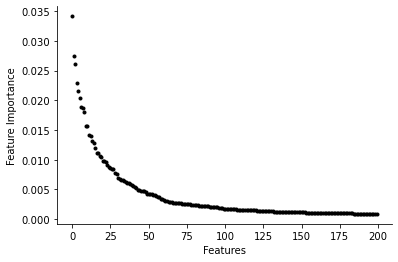

In [45]:
# View a list of the features and their importance scores 
output = list(zip(df_train[features], rf_clf.feature_importances_))

# convert list of tuples to a a list of lists 
output = [list(temp) for temp in output]

sorted_output = sorted(output,key=lambda l:l[1], reverse=True)

plt.close('all')
fig, axes = plt.subplots(nrows = 1, ncols = 1)
fig.set_facecolor('white')
axes.set_ylabel('Feature Importance')
axes.set_xlabel('Features')
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.yaxis.set_ticks_position('left')
axes.xaxis.set_ticks_position('bottom')
axes.tick_params(direction='out')

xmax = 200
axes.plot([i for i in range(xmax)], [temp[1] for i, temp in enumerate(sorted_output) if i < xmax],'k.', clip_on = False)
plt.show()

rate_of_change = [sorted_output[x][1] - sorted_output[x-1][1] for x in range(1, len(output))]

# Create a Colored PDB Image 

### Important Residues, because of alpha CA position

In [46]:
# Determine important Alpha Carbons
important_residues = []
importance_for_residues = []
cutoff = 0.00
count = 0
# if residue doesn't start at one include off shift
shift = 14
for i in range(int(len(output))):
    if (i+1) % 3 == 0:
        count += 1
        if output[i][1] > cutoff or output[i-1][1] > cutoff or output[i-2][1] > cutoff: 
            all_importance = [output[i][1], output[i-1][1], output[i-2][1]]
            importance_for_residues.append(max(all_importance))
            important_residues.append(count+shift)
            #print(count)
print(important_residues)
#print(importance)

[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231,

# Make Colored PDB file

In [47]:
print('# Atoms: {}'.format(len(apo_select)))
print('# Important Atoms: {}'.format(len(important_residues)))
print('# Percent Important: {0:0.2f}%'.format((len(important_residues)/len(apo_select))*100))

# Atoms: 329
# Important Atoms: 329
# Percent Important: 100.00%


In [48]:
# pdb for coloring
flag = 0
with open("importance_by_residues.pdb", "w") as o:
    with open("check.pdb", 'r') as f:
        for line in f:
            line.split(' ')
            if line.find("ATOM") != -1:
                if line.find("PROT") != -1:
                    parta = line[0:60]
                    partb = line[67:76]
                    #print(line[23:31])
                    if int(line[23:31]) == important_residues[flag]: # You might need to add a residue buffer here.
                        o.write("{}{:6.2f}{}\n".format(parta,importance_for_residues[flag]/max(importance_for_residues),partb))
                        #print("{}{:6.2f}{}\n".format(parta,importance[flag]/max(importance),partb))
                        if line.find(" O ") != -1 and flag < len(important_residues)-1:
                            flag += 1 
                    else:
                        o.write("{}{:6.2f}{}\n".format(parta,0.00,partb))
    o.write("END\n")    

# Remove Garbage Files

In [ ]:
os.system('rm apo.dcd')
os.system('rm holo.dcd')